In [37]:
%matplotlib inline
from numpy import *
from numpy.fft import fft,ifft,rfft,irfft
import scipy.signal as sig
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries

In [2]:
from gwpy.time import tconvert

In [145]:
st=tconvert('Oct 5 2016 13:00:00')
dur=600
print st

1159707617


In [146]:
try:
    darm=TimeSeries.read('L1-HOFT-%u-%u.hdf' % (st,dur))
    aux=TimeSeries.read('L1-DHARDY-%u-%u.hdf' % (st,dur))
except:
    darm=TimeSeries.fetch('L1:GDS-CALIB_STRAIN',st,st+dur)
    darm.write('L1-HOFT-%u-%u.hdf' % (st,dur))
    aux=TimeSeries.fetch('L1:ASC-DHARD_Y_OUT_DQ',st,st+dur)
    aux.write('L1-DHARDY-%u-%u.hdf' % (st,dur))

Find the PSD of DARM, and the coherence with the aux channel.

In [147]:
fftlen=32
overlap=24
coh=darm.coherence(aux,fftlen,overlap)
psd=darm.psd(fftlen,overlap)

Subtract the predicted effect of the aux channel on the PSD. Noises should add incoherently.

In [148]:
coh_long=zeros(len(psd),dtype=coh.dtype)
coh_long[:len(coh)]=coh.value

psd_sub=(1.-coh_long)*psd

(1e-47, 1e-38)

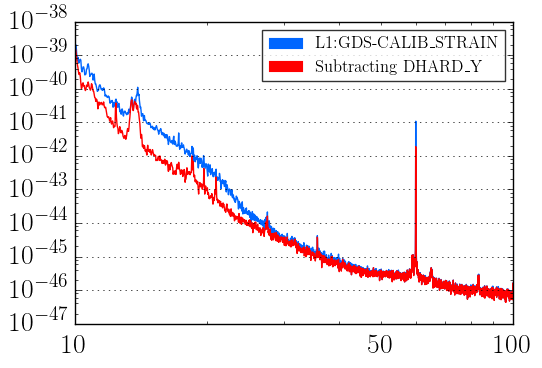

In [142]:
p1=psd.plot()
p1.gca().plot(psd_sub,label='Subtracting DHARD\_Y')
p1.set_xlim(10,100)
p1.set_ylim(1e-47,1e-38)

(1e-24, 1e-19)

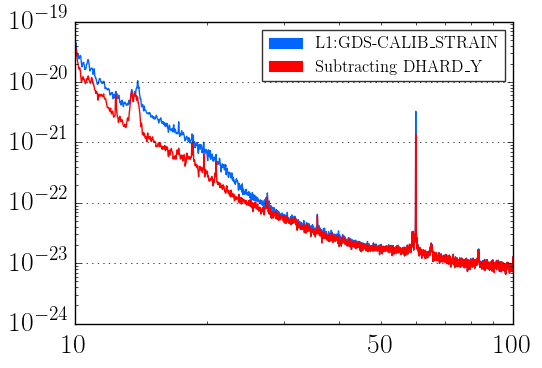

In [144]:
p1=(psd**0.5).plot()
p1.gca().plot(psd_sub**0.5,label='Subtracting DHARD\_Y')
p1.set_xlim(10,100)
p1.set_ylim(1e-24,1e-19)

In [128]:
def eff_range(my_psd,f_low,f_high):
    """ Calculate the sensemon range. This is just a quick
        estimation. It's mostly useful for comparing ranges
        with different PSDs or different frequency limits."""
    norm=1.8e-21 # Normalizing factor, eyeballed
    idx1=int(f_low/my_psd.df.value)
    idx2=int(f_high/my_psd.df.value)
    integrand=(my_psd.frequencies**(-7./3.)/my_psd).value
    return norm*sqrt(sum(integrand[idx1:idx2]))

In [149]:
eff_range(psd_sub,20,300)/eff_range(psd,20,300)

1.020491096760185